In [1]:
#import modules

import glob
import dask
import dask.dataframe as dd
import matplotlib.pyplot as plt
import time
import pandas as pd
from dask.distributed import Client
import numpy as np
import re
import datetime


/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 13.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
# File path
fpath =  '../data/accelerated_aging/accelerated_aging/*.csv'
#'../data/sensor2_12192023week1/first_cycle/*.csv'


In [3]:
#provide an unique name for svd file 
export_name = 'accelerated_aging'

In [4]:
# Set filtering conditions
k = ['Frame-00001', 'Frame-0001'] 
huang_rhys = [649, 780]
nv_zpl = [634.25, 640.25]
nv0_zpl = [572.0, 578]

In [5]:

# Compile regular expressions
laser_power_id = re.compile('laser_power_\\d*_')
temperature = re.compile('-?\\d*,\\d*')
acq_length = re.compile('\\d*\\.\\d*ms')
grating_center = re.compile('CWL\\d*\\.\\d*nm')
time_stamp = re.compile('202\\d \\w*\\s\\d* \\d*\\w\\d*_\\d*')
f_num = re.compile('Frame-\\d*')

In [6]:

# Functions to extract attributes
def extract_attributes(filename):
    lp = int(str(laser_power_id.findall(filename)).split('_')[2])
    t = float(temperature.findall(filename)[0].replace(',', '.'))
    a = float(acq_length.findall(filename)[0].replace('ms', ''))
    b = float(grating_center.findall(filename)[0].strip('CWL').strip('nm'))
    
    g = time_stamp.findall(filename)[0].split(' ')
    year, month_str, day, hr = g[0], g[1], g[2], g[3]
    h, m, s = hr.split('_')
    month = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 
              'May': 5, 'June': 6, 'July': 7, 'August': 8, 
              'September': 9, 'October': 10, 'November': 11, 'December': 12}[month_str]
    
    mt = time.mktime(datetime.datetime(int(year), month, int(day), int(h), int(m), int(s)).timetuple())
    fnm = int(f_num.findall(filename)[0].split('-')[1])
    
    return mt, lp, t, a, b, fnm


In [7]:
# File filtering function
def filter_files(file_list):
    filtered_files = sorted([f for f in file_list if all(kw not in f for kw in k)], key=lambda x: extract_attributes(x)[0])
    return filtered_files 

In [8]:

# assemble svd_matrix
def process_svd_matrix(file_path):
    
    df_ = pd.read_csv(file_path, sep=',', usecols=['Intensity'])
    df_.columns = [extract_attributes(file_path)[2]]
    return df_

In [9]:
# load in file names

files = filter_files(glob.glob(fpath))
len(files)

549394

In [10]:
# Load reference spectrum and normalize
df0 = pd.read_csv(files[1], sep=',' ,  usecols= ['Wavelength'])

In [11]:
    
# Initialize Dask client
client = Client(n_workers=10, threads_per_worker=1, memory_limit='14GB')

/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46263 instead
  warnings.warn(


In [12]:
# Create and compute delayed tasks
start_time = time.time()
delayed_results = [dask.delayed(process_svd_matrix)(f) for f in files[:]]
results = dask.compute(*delayed_results)
df__ = pd.concat(results, axis=1)
df_s = pd.concat([df0,df__], axis = 1)

/home/zahmed/.conda/envs/sams/lib/python3.9/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 128.19 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [13]:
df_s.head()

,Wavelength,69.999,69.999,69.999,69.999,69.999,69.999,69.999,69.999,69.999,...,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0
0,613.158134,976,1031,1051,1041,1040,1041,1024,1038,1063,...,912,963,1010,906,940,994,978,929,842,828
1,613.288264,934,999,1024,1060,1049,1005,1024,937,1039,...,878,845,946,967,989,973,870,845,921,876
2,613.418394,1049,958,1094,1000,1070,1030,1037,983,1051,...,920,996,899,889,904,923,898,945,979,946
3,613.548522,1103,1049,1020,1077,1052,1096,1054,1072,1020,...,939,873,967,999,882,954,901,864,898,955
4,613.678650,1015,1058,1109,1081,1018,1058,1062,1133,1048,...,954,975,887,932,949,940,934,1000,969,914


In [14]:
df_s.rename(columns={'Wavelength':'temperature'}, inplace=True)
df_s.head()

,temperature,69.999,69.999,69.999,69.999,69.999,69.999,69.999,69.999,69.999,...,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0
0,613.158134,976,1031,1051,1041,1040,1041,1024,1038,1063,...,912,963,1010,906,940,994,978,929,842,828
1,613.288264,934,999,1024,1060,1049,1005,1024,937,1039,...,878,845,946,967,989,973,870,845,921,876
2,613.418394,1049,958,1094,1000,1070,1030,1037,983,1051,...,920,996,899,889,904,923,898,945,979,946
3,613.548522,1103,1049,1020,1077,1052,1096,1054,1072,1020,...,939,873,967,999,882,954,901,864,898,955
4,613.678650,1015,1058,1109,1081,1018,1058,1062,1133,1048,...,954,975,887,932,949,940,934,1000,969,914


In [15]:
# prepare the de-meaned data matrix
df_sm = df_s.T
df_sm.columns = df_sm.iloc[0]
df_sm.drop('temperature', inplace=True)
df_sm = df_sm - df_sm.mean()

In [16]:
df_sm.columns

Index([613.1581342695605, 613.2882643171293, 613.4183935430451,
       613.5485219466715, 613.6786495273719, 613.8087762845105,
       613.9389022174508, 614.0690273255567, 614.1991516081921,
       614.3292750647204,
       ...
        785.257345426425, 785.3858247710828, 785.5143024593286,
       785.6427784905485, 785.7712528641274, 785.8997255794505,
       786.0281966359041, 786.1566660328739, 786.2851337697449,
        786.413599845903],
      dtype='float64', name='temperature', length=1340)

In [17]:
df_sm.tail(3)

temperature,613.158134,613.288264,613.418394,613.548522,613.678650,613.808776,613.938902,614.069027,614.199152,614.329275,...,785.257345,785.385825,785.514302,785.642778,785.771253,785.899726,786.028197,786.156666,786.285134,786.413600
25.0,-70.306933,-154.550792,-61.339166,-152.99628,-22.372505,-60.375577,-20.633645,-91.326298,-159.005668,-109.035728,...,244.504054,134.157011,287.53187,88.595472,307.936541,192.137357,242.840639,175.87031,10.553901,165.677929
25.0,-157.306933,-78.550792,-27.339166,-118.99628,-53.372505,-113.375577,-74.633645,-93.326298,-134.005668,-67.035728,...,199.504054,224.157011,155.53187,97.595472,45.936541,103.137357,185.840639,164.87031,170.553901,307.677929
25.0,-171.306933,-123.550792,-60.339166,-61.99628,-108.372505,-47.375577,-127.633645,-19.326298,-96.005668,-89.035728,...,255.504054,239.157011,126.53187,53.595472,142.936541,39.137357,241.840639,193.87031,84.553901,103.677929


In [18]:
#save the data matrix
save_path = '../saved_data/demeaned_data_matrix_'+export_name


In [19]:
df_sm.to_csv(save_path)

In [20]:

print(time.time() -  start_time)

client.close()


2064.2691509723663


<AxesSubplot:xlabel='temperature'>

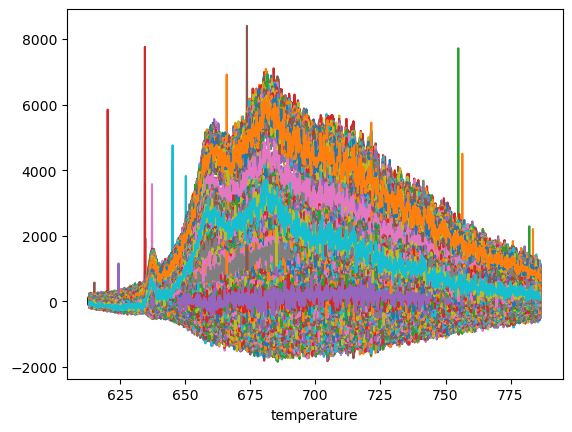

In [21]:
df_sm.iloc[::10, :].T.plot(legend=False)

In [22]:
df_sm.shape

(549394, 1340)